In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Adjacency Matrix

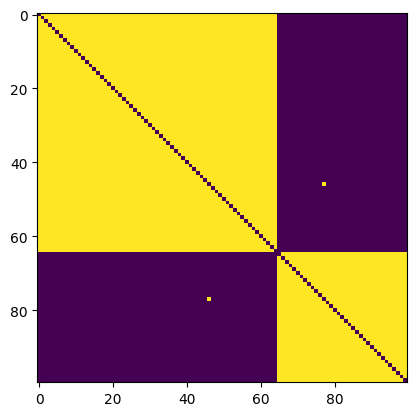

In [2]:
n = 100
dt = 0.001
T = 1

# # default, connected
# A = np.ones((n,n))
# A = np.triu(A, 1)
# A = A + A.T

# # Erdos Renyi
# p = .2
# A = np.random.rand(n,n) # random matrix
# A = np.where(A < p, 1, 0) # adjacency matrix
# A = np.triu(A, 1) # triangular matrix
# A = A + A.T # symmetric matrix

# # Small World
# A = np.zeros((n,n))
# for i in range(n):
#     for j in range(n):
#         if i == j:
#             continue
#         if np.abs(i-j) < 5:
#             A[i,j] = 1
#         elif np.abs(i-j) > n-5:
#             A[i,j] = 1
#         else:
#             A[i,j] = 0


pop = np.random.randint(25,75) #minimum and maximum population sizes
A = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if i == j:
            A[i,j] = 0
        elif (i <= pop and j <= pop) or (i > pop and j > pop):
            A[i,j] = 1
        else:
            A[i,j] = 0
sender = np.random.randint(0,pop+1)
receiver = np.random.randint(pop+1,99)
A[sender,receiver] = 1
A[receiver,sender] = 1

# plot
plt.imshow(A)
plt.show()

### Information Accumulation Process & Kick Weight

In [3]:
mu = np.ones(n) # diffusion, i.e. correct decision
W = lambda: np.random.randn(n)*10 # drift, randon Weiner process

def dydt(A, zeta, mu, w, kicks, dt):
    """Information Accumulation Model
    Args:
        A (nxn): adjacency matrix
        zeta (nx1): drift at current time
        mu (nx1): diffusion
        w (nx1): update weights
        kicks (nx1): kick at current time
        dt (float): time step
    Returns:
        np.ndarray: dydt
    """
    return (mu + np.sqrt(2)*zeta)*dt + w*A.dot(kicks)

def dwdt(A, kappa, gamma, w, kicks, dt,tau = 1):
    """Kick weights
    Args:
        A (nxn): adjacency matrix
        kappa (nx1): learning rate
        gamma (nx1): forgetting rate
        w (nx1): update weights
        kicks (nx1): kick at current time
        dt (float): time step
    Returns:
        np.ndarray: dwdt
    """
    return (kappa - w)*dt/tau - gamma*w*np.where(A.dot(np.abs(kicks)) > 1, 1, A.dot(np.abs(kicks)))


### Simulation

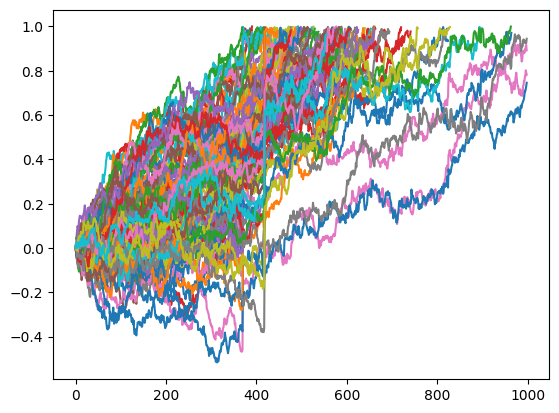

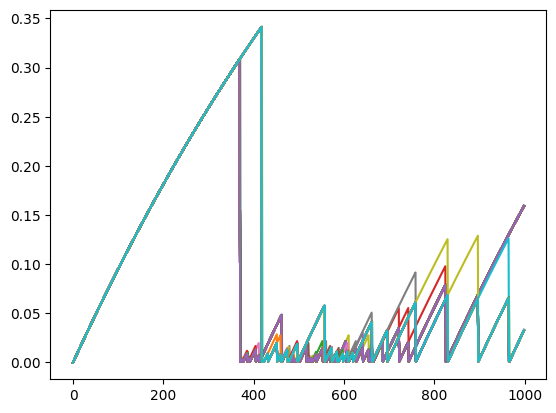

In [11]:
# parameters
kappa = 1
gamma = 1
tau = 1
stopcondition = 1

# initial conditions
y = np.zeros((n, int(T/dt)))
w = np.zeros((n, int(T/dt)))

# initial kick
kicks = np.zeros(n)

# stoptime
tstop = int(T/dt)-1

# simulation
for t in range(int(T/dt)-1):
    # drift
    zeta = W()
    # update state
    y[:,t+1] = y[:,t] + dydt(A, zeta, mu, w[:,t], kicks, dt)
    # update kick weights
    w[:,t+1] = w[:,t] + dwdt(A, kappa, gamma, w[:,t], kicks, dt,tau)
    # update kick
    kp = np.where(y[:,t+1] < np.inf, y[:,t+1], 0) 
    kp = kp > mu
    km = np.where(y[:,t+1] > -np.inf, y[:,t+1], 0)
    km = km < -mu
    kicks = np.where(kp, 1, 0) - np.where(km, 1, 0)
    # set to inf
    y[:,t+1] = np.where(y[:,t+1] > 1, np.inf, y[:,t+1])
    y[:,t+1] = np.where(y[:,t+1] < -1, -np.inf, y[:,t+1])
    # stop condition
    if (np.sum(y[:,t+1] == np.inf) + np.sum(y[:,t+1] == -np.inf))/len(y[:,t+1]) >= stopcondition:
        tstop = t+1
        break

# plot
plt.plot(y[:,:tstop].T)
plt.show()

plt.plot(w[:,:tstop].T)
plt.show()

In [12]:
# count number of positive and negative infinities
pos = np.sum(y[:,tstop] == np.inf)
neg = np.sum(y[:,tstop] == -np.inf)
print("CIN", pos, neg, n-pos-neg)

CIN 96 0 4


In [13]:
def RR(yvec,correct,tstop): #Calculating the reward rate of the given population (accuracy/total time to decide)
    cor = 0
    inc = 0
    und = 0
    for i in yvec:
        if i == correct*np.inf:
            cor += 1
        elif i == -np.inf*correct:
            inc += 1
        else:
            und += 1
    return (cor/(inc+und+cor))/tstop

RR(y[:,tstop],1,tstop)

0.0009609609609609609